In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from mcs_prime import McsTracks, PATHS
%matplotlib inline

Load all tracks from 2000/6-2020/12

In [2]:
tracks = tracks = McsTracks.mfload(str(PATHS['statsdir'] / 'mcs_tracks_final_extc_*.0000.nc'), 
                                   PATHS['pixeldir'], 
                                   False)
ntracks = len(tracks.dstracks.tracks)
tracks

McsTracks[2000-06-01 00:30:00.000013440, 2020-12-31 22:30:00, ntracks=696293]

`McsTracks` provides a wrapper around a `dstracks` object, which is an `xarray.DataSet`.

In [3]:
tracks.dstracks

<xarray.Dataset>
Dimensions:                  (tracks: 696293, times: 400, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 696290 696291 696292
  * times                    (times) int64 0 1 2 3 4 5 ... 395 396 397 398 399
  * mergers                  (mergers) int64 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 0 1 2
Data variables: (12/55)
    track_duration           (tracks) int32 dask.array<chunksize=(21142,), meta=np.ndarray>
    start_status             (tracks) int32 dask.array<chunksize=(21142,), meta=np.ndarray>
    end_status               (tracks) int32 dask.array<chunksize=(21142,), meta=np.ndarray>
    start_basetime           (tracks) datetime64[ns] dask.array<chunksize=(21142,), meta=np.ndarray>
    end_basetime             (tracks) datetime64[ns] dask.array<chunksize=(21142,), meta=np.ndarray>
    start_split_cloudnumber  (tracks) int32 dask.array<chunksize=(21142,), meta=np.ndarray>
    ...                       ...
    pf_mcsstatus             (tracks, times) int64 dask.array<chunksize=(21142, 400), meta=np.ndarray>
    movement_distance        (tracks, times) float32 dask.array<chunksize=(21142, 400), meta=np.ndarray>
    movement_speed           (tracks, times) float32 dask.array<chunksize=(21142, 400), meta=np.ndarray>
    movement_theta           (tracks, times) float32 dask.array<chunksize=(21142, 400), meta=np.ndarray>
    movement_distance_x      (tracks, times) float32 dask.array<chunksize=(21142, 400), meta=np.ndarray>
    movement_distance_y      (tracks, times) float32 dask.array<chunksize=(21142, 400), meta=np.ndarray>
Attributes: (12/23)
    Title:                       Statistics of each MCS track
    Institution:                 Pacific Northwest National Laboratory
    Contact:                     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                  Wed Mar  9 18:38:34 2022
    startdate:                   20000601.0000
    enddate:                     20010101.0000
    ...                          ...
    PF_PF_min_majoraxis_thresh:  20
    coefs_pf_area:               [2874.05    89.825]
    coefs_pf_rr:                 [3.01657   0.0144461]
    coefs_pf_skew:               [0.194462  0.0100072]
    coefs_pf_heavyratio:         [3.419024 0.438709]
    max_speed_thresh:            50

In [4]:
nanmask = ~np.isnan(tracks.dstracks.meanlon.values)
print(nanmask.sum())
print(tracks.dstracks.track_duration.values.sum()) 
# Why are these off by one?

12648956
12648957


Histograms
--------------

In [5]:
np.percentile(tracks.dstracks.track_duration.values, [33.3, 66.6])

array([12., 20.])

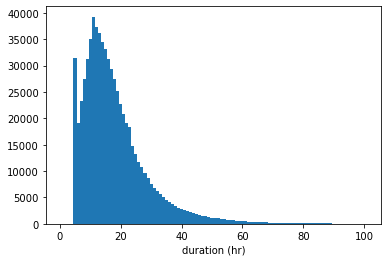

In [6]:
plt.hist(tracks.dstracks.track_duration.values, bins=np.linspace(0, 100, 101) + 0.5)
plt.xlabel('duration (hr)');
# Why is there a spike at n=4?

502 696293 696293


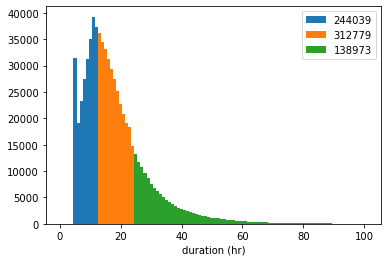

In [7]:
# Use 12, 24 as natural thresholds to split durations into roughly 3:
(n12, n12_24, n24_100, n100), _ = np.histogram(tracks.dstracks.track_duration.values, 
                                               bins=[0.5, 12.5, 24.5, 100.5, 1000])
plt.hist(tracks.dstracks.track_duration.values, bins=np.linspace(0, 12, 13) + 0.5, label=n12)
plt.hist(tracks.dstracks.track_duration.values, bins=np.linspace(12, 24, 13) + 0.5, label=n12_24)
plt.hist(tracks.dstracks.track_duration.values, bins=np.linspace(24, 100, 77) + 0.5, label=n24_100)
plt.legend()
plt.xlabel('duration (hr)')
# Sanity check on ntracks.
print(n100, n12 + n12_24 + n24_100 + n100, ntracks)

In [8]:
max_areas = np.nanmax(tracks.dstracks.area.values, axis=1)
mean_areas = np.nanmean(tracks.dstracks.area.values, axis=1)
max_area_thresh = np.percentile(max_areas, [25, 50, 75])
mean_area_thresh = np.percentile(mean_areas, [25, 50, 75])
print(max_area_thresh)
print(mean_area_thresh)

[ 94900. 150100. 271000.]
[ 48684.2109375  74725.        132014.28125  ]


696293 696293


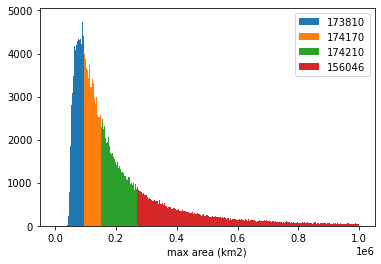

696293 696293


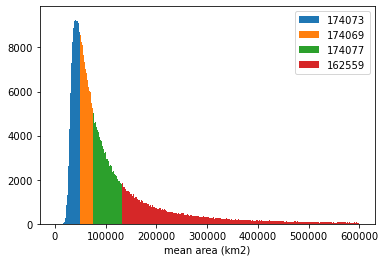

In [9]:
def area_hist(areas, bins, mode):
    bin_nums, _ = np.histogram(areas, bins)
    for i in range(len(bins) - 2):
        dbin = bins[i + 1] - bins[i]
        plt.hist(areas, bins=np.linspace(bins[i], bins[i + 1], int(dbin / 1000)), label=bin_nums[i])
    plt.legend()
    plt.xlabel(f'{mode} area (km2)')
    # Sanity check on ntracks.
    print(sum(bin_nums), ntracks)
    
bins = [0] + list(max_area_thresh) + [1e6, 1e7]
area_hist(max_areas, bins, 'max')
plt.show()

bins = [0] + list(mean_area_thresh) + [0.6e6, 1e7]
area_hist(mean_areas, bins, 'mean')

LinregressResult(slope=0.46786757035956866, intercept=6983.960350932321, rvalue=0.9379662039347544, pvalue=0.0, stderr=0.00020726579707456866, intercept_stderr=75.65187818266733)
0.8797805997237732


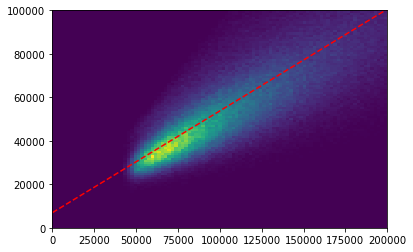

In [10]:
plt.hist2d(max_areas, mean_areas, bins=(np.linspace(0, 2e5, 100), np.linspace(0, 1e5, 100)))
reg = stats.linregress(max_areas, mean_areas)
x = np.array([0, 2e5])
plt.plot(x, reg.intercept + reg.slope * x, 'r--')
print(reg)
print(reg.rvalue**2)

9.972


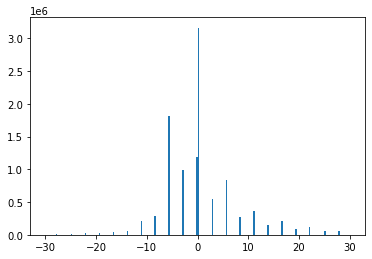

In [11]:
# N.B. movement_dist_x is in km/hr - convert to m/s by dividing by 3.6
plt.hist(tracks.dstracks.movement_distance_x.values[nanmask] / 3.6, bins=np.arange(-30, 30.25, 0.25))
# Clear that data are distributed discontinuously - roughly every 2.77 m/s.
print(2.77 * 3.6)
# Or every 10 km (this is probably the mean gridlength at 0.1deg resolution)

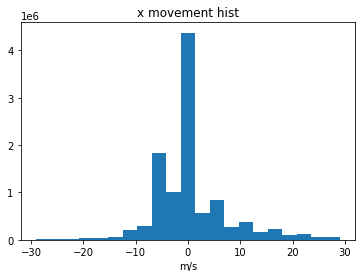

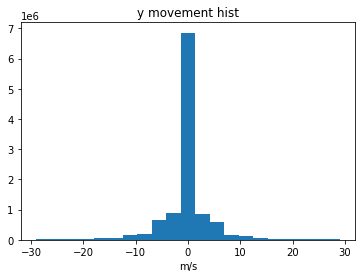

In [12]:
dbin = 2.77
bins = np.arange(-10 * dbin - dbin / 2, 11 * dbin + dbin / 2, dbin)
plt.hist(tracks.dstracks.movement_distance_x.values[nanmask] / 3.6, bins=bins)
plt.title('x movement hist')
plt.xlabel('m/s')
plt.show()

plt.hist(tracks.dstracks.movement_distance_y.values[nanmask] / 3.6, bins=bins)
plt.title('y movement hist')
plt.xlabel('m/s');
# There seems to be an aliasing effect or similar for x - every 2nd value for +ve x is larger.

Area/precip area growth
-------------------

In [13]:
area_growth = tracks.dstracks.area[:, 1:].values - tracks.dstracks.area[:, :-1].values
total_rain_growth = tracks.dstracks.total_rain[:, 1:].values - tracks.dstracks.total_rain[:, :-1].values

growth_nanmask = ~np.isnan(area_growth)

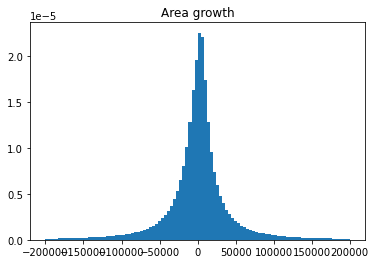

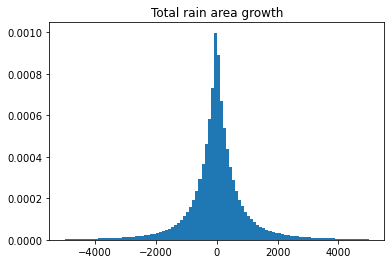

In [14]:
bins = np.linspace(-2e5, 2e5, 101)
plt.hist(area_growth[growth_nanmask], bins=bins, density=True)
plt.title('Area growth')
plt.show()

bins = np.linspace(-5000, 5000, 101)
plt.hist(total_rain_growth[growth_nanmask], bins=bins, density=True);
plt.title('Total rain area growth');

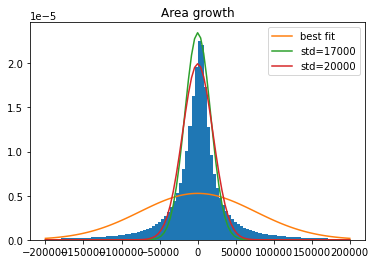

In [15]:
# Wonder how these are distributed? A normal distribution does not fit:
from scipy.stats import norm 
mean, std = norm.fit(area_growth[growth_nanmask]) 
bins = np.linspace(-2e5, 2e5, 101)
plt.hist(area_growth[growth_nanmask], bins=bins, density=True)
plt.plot(bins, norm.pdf(bins, mean, std), label='best fit')
plt.plot(bins, norm.pdf(bins, mean, 17000), label='std=17000')
plt.plot(bins, norm.pdf(bins, mean, 20000), label='std=20000')
plt.legend()
plt.title('Area growth');